In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import fsps
import prospect
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
from astropy.cosmology import WMAP9 as cosmo

In [3]:
from prospect.models.templates import TemplateLibrary
TemplateLibrary.describe("dirichlet_sfh")


Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  z_fraction: <class 'prospect.models.priors.Beta'>(mini=0.0,maxi=1.0,alpha=1.0,beta=1.0)
  total_mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  mass: 1.0 <function zfrac_to_masses at 0x17c12b7e0>
  sfh: 3 
  imf_type: 2 
  dust_type: 0 
  agebins: [[0.0, 8.0], [8.0, 9.0], [9.0, 10.0]] 


In [4]:
def convert_sfh(agebins, mformed, epsilon=1e-4, maxage=None):
        """Given arrays of agebins and formed masses with each bin, calculate a
        tabular SFH.  The resulting time vector has time points either side of
        each bin edge with a "closeness" defined by a parameter epsilon.

        :param agebins:
            An array of bin edges, log(yrs).  This method assumes that the
            upper edge of one bin is the same as the lower edge of another bin.
            ndarray of shape ``(nbin, 2)``

        :param mformed:
            The stellar mass formed in each bin.  ndarray of shape ``(nbin,)``

        :param epsilon: (optional, default 1e-4)
            A small number used to define the fraction time separation of
            adjacent points at the bin edges.

        :param maxage: (optional, default: ``None``)
            A maximum age of stars in the population, in yrs.  If ``None`` then the maximum
            value of ``agebins`` is used.  Note that an error will occur if maxage
            < the maximum age in agebins.

        :returns time:
            The output time array for use with sfh=3, in Gyr.  ndarray of shape (2*N)

        :returns sfr:
            The output sfr array for use with sfh=3, in M_sun/yr.  ndarray of shape (2*N)

        :returns maxage:
            The maximum valid age in the returned isochrone.
        """
        #### create time vector
        agebins_yrs = 10**agebins.T
        dt = agebins_yrs[1, :] - agebins_yrs[0, :]
        bin_edges = np.unique(agebins_yrs)
        if maxage is None:
            maxage = agebins_yrs.max()  # can replace maxage with something else, e.g. tuniv
        t = np.concatenate((bin_edges * (1.-epsilon), bin_edges * (1+epsilon)))
        t.sort()
        t = t[1:-1] # remove older than oldest bin, younger than youngest bin
        fsps_time = maxage - t

        #### calculate SFR at each t
        sfr = mformed / dt
        sfrout = np.zeros_like(t)
        sfrout[::2] = sfr
        sfrout[1::2] = sfr  # * (1+epsilon)

        return (fsps_time / 1e9)[::-1], sfrout[::-1], maxage / 1e9

In [5]:
def zfrac_to_masses(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to sfr
    fractions and then to bin mass fractions. The transformation is such that
    sfr fractions are drawn from a Dirichlet prior.  See Betancourt et al. 2010
    and Leja et al. 2017

    Parameters
    ----------
    total_mass : float
        The total mass formed over all bins in the SFH.

    z_fraction : ndarray of shape ``(Nbins-1,)``
        latent variables drawn from a specific set of Beta distributions. (see
        Betancourt 2010)

    Returns
    -------
    masses : ndarray of shape ``(Nbins,)``
        The stellar mass formed in each age bin.
    """
    # sfr fractions
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])

    # convert to mass fractions
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    if (mass_fraction < 0).any():
        idx = mass_fraction < 0
        if np.isclose(mass_fraction[idx],0,rtol=1e-8):
            mass_fraction[idx] = 0.0
        else:
            raise ValueError('The input z_fractions are returning negative masses!')

    masses = total_mass * mass_fraction
    return masses


In [6]:
def zred_to_agebins(zred=0.0, agebins=[], **extras):
    """Set the nonparameteric SFH age bins depending on the age of the universe
    at ``zred``. The first bin is not altered and the last bin is always 15% of
    the upper edge of the oldest bin, but the intervening bins are evenly
    spaced in log(age).

    Parameters
    ----------
    zred : float
        Cosmological redshift.  This sets the age of the universe.

    agebins :  ndarray of shape ``(nbin, 2)``
        The SFH bin edges in log10(years).

    Returns
    -------
    agebins : ndarray of shape ``(nbin, 2)``
        The new SFH bin edges.
    """
    tuniv = cosmo.age(zred).value * 1e9
    tbinmax = tuniv * 0.85
    ncomp = len(agebins)
    agelims = list(agebins[0]) + np.linspace(agebins[1][1], np.log10(tbinmax), ncomp-2).tolist() + [np.log10(tuniv)]
    return np.array([agelims[:-1], agelims[1:]]).T

In [71]:
def zfrac_to_sfr(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to SFRs.

    :returns sfrs:
        The SFR in each age bin (msun/yr).
    """
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    masses = zfrac_to_masses(total_mass, z_fraction, agebins)
    return masses / time_per_bin

def mwa(sfrs, total_mass_formed, agebins):
    """mass-weighted age, vectorized
    """
    ages = 10**(agebins)
    dtsq = (ages[:, 1]**2 - ages[:, 0]**2) / 2
    mwa = [(dtsq * sfr).sum() / mass
           for sfr, mass in zip(sfrs, total_mass_formed)]
    return np.array(mwa) / 1e9


def mwa(sfrs, agebins, mass):

    ages = 10**(agebins)
    t = (ages[:, 1] - ages[:, 0])/2 + ages[:, 0] #midpoint
    t_grid = np.linspace(ages[0,0], ages[-1,1], 100)
    sfrs_interp = np.interp(t_grid, t, sfrs)
    plt.plot(t, sfrs)
    plt.plot(t_grid, sfrs_interp)

    return (10**-9)*np.trapz(sfrs_interp*t_grid, t_grid)/mass

In [8]:
#Dirichlet prior
def generate_tabulated_sfh(redshift, concentration_parameter, total_mass_formed):
    #look back time
    age_bins = np.log10(np.array([[10**-9, 30*0.001],
                        [30*0.001, 100*0.001],
                        [100*0.001, 330*0.001],  
                        [330*0.001, 1.1], 
                        [1.1, 3.6],
                        [3.6, 11.7],
                        [11.7, 13.7]])*10**9)
    #age_bins = zred_to_agebins(redshift, age_bins)
    nbins = len(age_bins)
    alphas = np.ones((nbins-1,))*concentration_parameter
    z_fractions = dirichlet(alphas).rvs().reshape((nbins-1,))
    masses_formed = zfrac_to_masses(total_mass_formed, z_fractions, age_bins)
    sf_grid, sfrs, maxage = convert_sfh(age_bins, masses_formed)

    return [sf_grid, sfrs, maxage]

#Dirichlet prior
def generate_sfh(redshift, concentration_parameter, total_mass_formed):
    age_bins = np.log10(np.array([[10**-9, 30*0.001],
                        [30*0.001, 100*0.001],
                        [100*0.001, 330*0.001],  
                        [330*0.001, 1.1], 
                        [1.1, 3.6],
                        [3.6, 11.7],
                        [11.7, 13.7]])*10**9)
    #age_bins = zred_to_agebins(redshift, age_bins)
    nbins = len(age_bins)
    alphas = np.ones((nbins-1,))*concentration_parameter
    z_fractions = dirichlet(alphas).rvs().reshape((nbins-1,))
    sfh = zfrac_to_sfr(total_mass_formed, z_fractions, age_bins)

    return [sfh, age_bins]



In [9]:
def generate_multiple_tabulated_sfh(nsamples, redshift, concentration_parameter, total_mass_formed):

    i = 0
    sfhs = []
    while(i < nsamples):
        sfh_outputs = generate_tabulated_sfh(redshift, concentration_parameter, total_mass_formed)
        sfhs.append(sfh_outputs[1])
        i+=1

    grid = sfh_outputs[0]

    return [np.asarray(sfhs), grid]

def generate_multiple_sfh(nsamples, redshift, concentration_parameter, total_mass_formed):

    i = 0
    sfhs = []
    while(i < nsamples):
        sfh_outputs = generate_sfh(redshift, concentration_parameter, total_mass_formed)
        sfhs.append(sfh_outputs[0])
        i+=1

    bins = sfh_outputs[1]

    return [np.asarray(sfhs), bins]



Text(0, 0.5, '$M_{\\mathrm{sun}}$yr$^{-1}$')

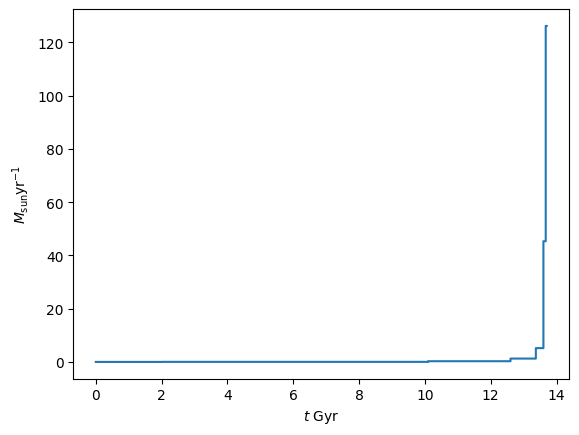

In [10]:
sf_grid, sfrs, maxage = generate_tabulated_sfh(0.01, 1.0, 10**10)
plt.plot(sf_grid, sfrs)
plt.xlabel("$t$ Gyr")
plt.ylabel("$M_{\mathrm{sun}}$yr$^{-1}$")

In [63]:
mass_formed = 10**10
sfhs = generate_multiple_sfh(1, 0.01, 1.0, mass_formed)
ages = mwa(np.reshape(sfhs[0], (sfhs[0].shape[1],)), sfhs[1], mass_formed)
ages

0.21425833555899848

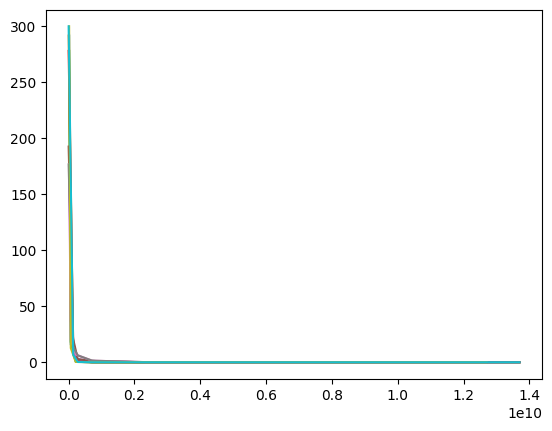

In [73]:
i = 0
ages = []
while(i < 5):
    sfhs = generate_multiple_sfh(1, 0.01, 1.0, mass_formed)
    ages.append(mwa(np.reshape(sfhs[0], (sfhs[0].shape[1],)), sfhs[1], mass_formed))
    i+=1

(array([251., 224., 188., 123.,  87.,  66.,  34.,  17.,   7.,   3.]),
 array([8.09254856e-05, 9.76425413e-02, 1.95204157e-01, 2.92765773e-01,
        3.90327389e-01, 4.87889005e-01, 5.85450620e-01, 6.83012236e-01,
        7.80573852e-01, 8.78135468e-01, 9.75697084e-01]),
 <BarContainer object of 10 artists>)

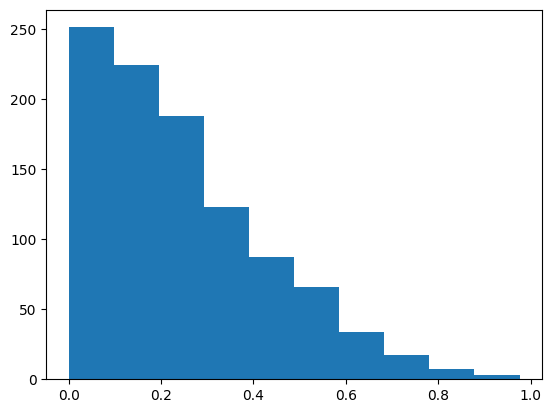

In [67]:
plt.hist(ages)